# Importing all the required libraries for this project

In [2]:
import os
import json
import h5py
import urllib.request
import numpy as np
import pickle as pk
from IPython.display import Image, display, clear_output

In [3]:
from keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.

# Models

In [7]:
model1 = VGG16(weights = 'imagenet')
model2 = load_model('/content/drive/MyDrive/data4/ft_model.keras')
model3 = load_model('/content/drive/MyDrive/data4/ft_model.keras')
model4 = load_model('/content/drive/MyDrive/data4/ft_model.keras')

In [9]:
import json
import pickle

# Download the ImageNet class index
import urllib.request
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_file = "imagenet_classes.txt"
urllib.request.urlretrieve(url, class_file)

# Read the class labels
with open(class_file, 'r') as f:
    class_names = [line.strip() for line in f]

# Save it as a pickle file
with open('vgg16_cat_list.pk', 'wb') as pk_file:
    pickle.dump(class_names, pk_file)

print("vgg16_cat_list.pk created successfully.")


vgg16_cat_list.pk created successfully.


In [10]:
with open('vgg16_cat_list.pk', 'rb') as f:
    cat_list = pk.load(f)

# Path 1: Check for car

In [11]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [12]:
def prepare_image_224(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [14]:
def path1(img_224, model):
    print("Ensuring entered picture is a car...")
    out = model.predict(img_224)
    preds = get_predictions(out, top=5)
    for pred in preds[0]:
        if pred[0:2] in cat_list:
            return True #"Successful. Proceeding to damage assessment..."
    return False #"The entered image is a not a car. Please try again. Consider a different angle or lighting."

# Path 2: Checking for damage

In [15]:
def prepare_img_256(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    return x

In [16]:
def path2(img_256, model):
    print("Validating that damage exists....")
    pred = model.predict(img_256)
    if(pred[0][0]<=0.5):
        return True #print("Validation complete - proceed to location and severity determination")
    else:
        return False
        #print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        #print ("Hint: Try zooming in/out, using a different angle or different lighting")

# Path 3: Location and Severity assessment

In [18]:
def path3_loc(img_256, model):
    print("Determining location of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'front', 1:'rear', 2:'side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Result: damage to {} of vehicle".format(d[key]))
    print("Location assessment complete.")

In [19]:
def path4_sev(img_256, model):
    print("Determining severity of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'minor', 1:'moderate', 2:'severe'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Result:{} damage".format(d[key]))
    print("Severity assessment complete.")

# Complete Pathway

In [20]:
def pathway(img_path):
    while True:
        #print("Submit image link (or type 'exit' to quit)")
        #img_path = input("Upload Image File Here:")
        #if img_path == 'exit':
        #    return None
        #clear_output()
        img_224 = prepare_image_224(img_path)
        p1 = path1(img_224, model1)
        display(Image('save.jpg', width=300))
        if p1 is False:
            print("The entered image is a not a car. Please try again. Consider a different angle or lighting.")
            break
        else:
            print("Successful. Proceeding to damage assessment...")

        img_256 = prepare_img_256(img_path)
        p2 = path2(img_256, model2)

        if p2 is False:
            print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
            print ("Hint: Try zooming in/out, using a different angle or different lighting")
            break
        else:
            print("Validation complete - proceed to location and severity determination")

        x = path3_loc(img_256, model3)
        y = path4_sev(img_256, model4)
        break

In [26]:
!pip install tensorflow
import tensorflow as tf

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        # Use tf.keras.utils.get_file instead of keras.utils.data_utils.get_file
        fpath = tf.keras.utils.get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

Ensuring entered picture is a car...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


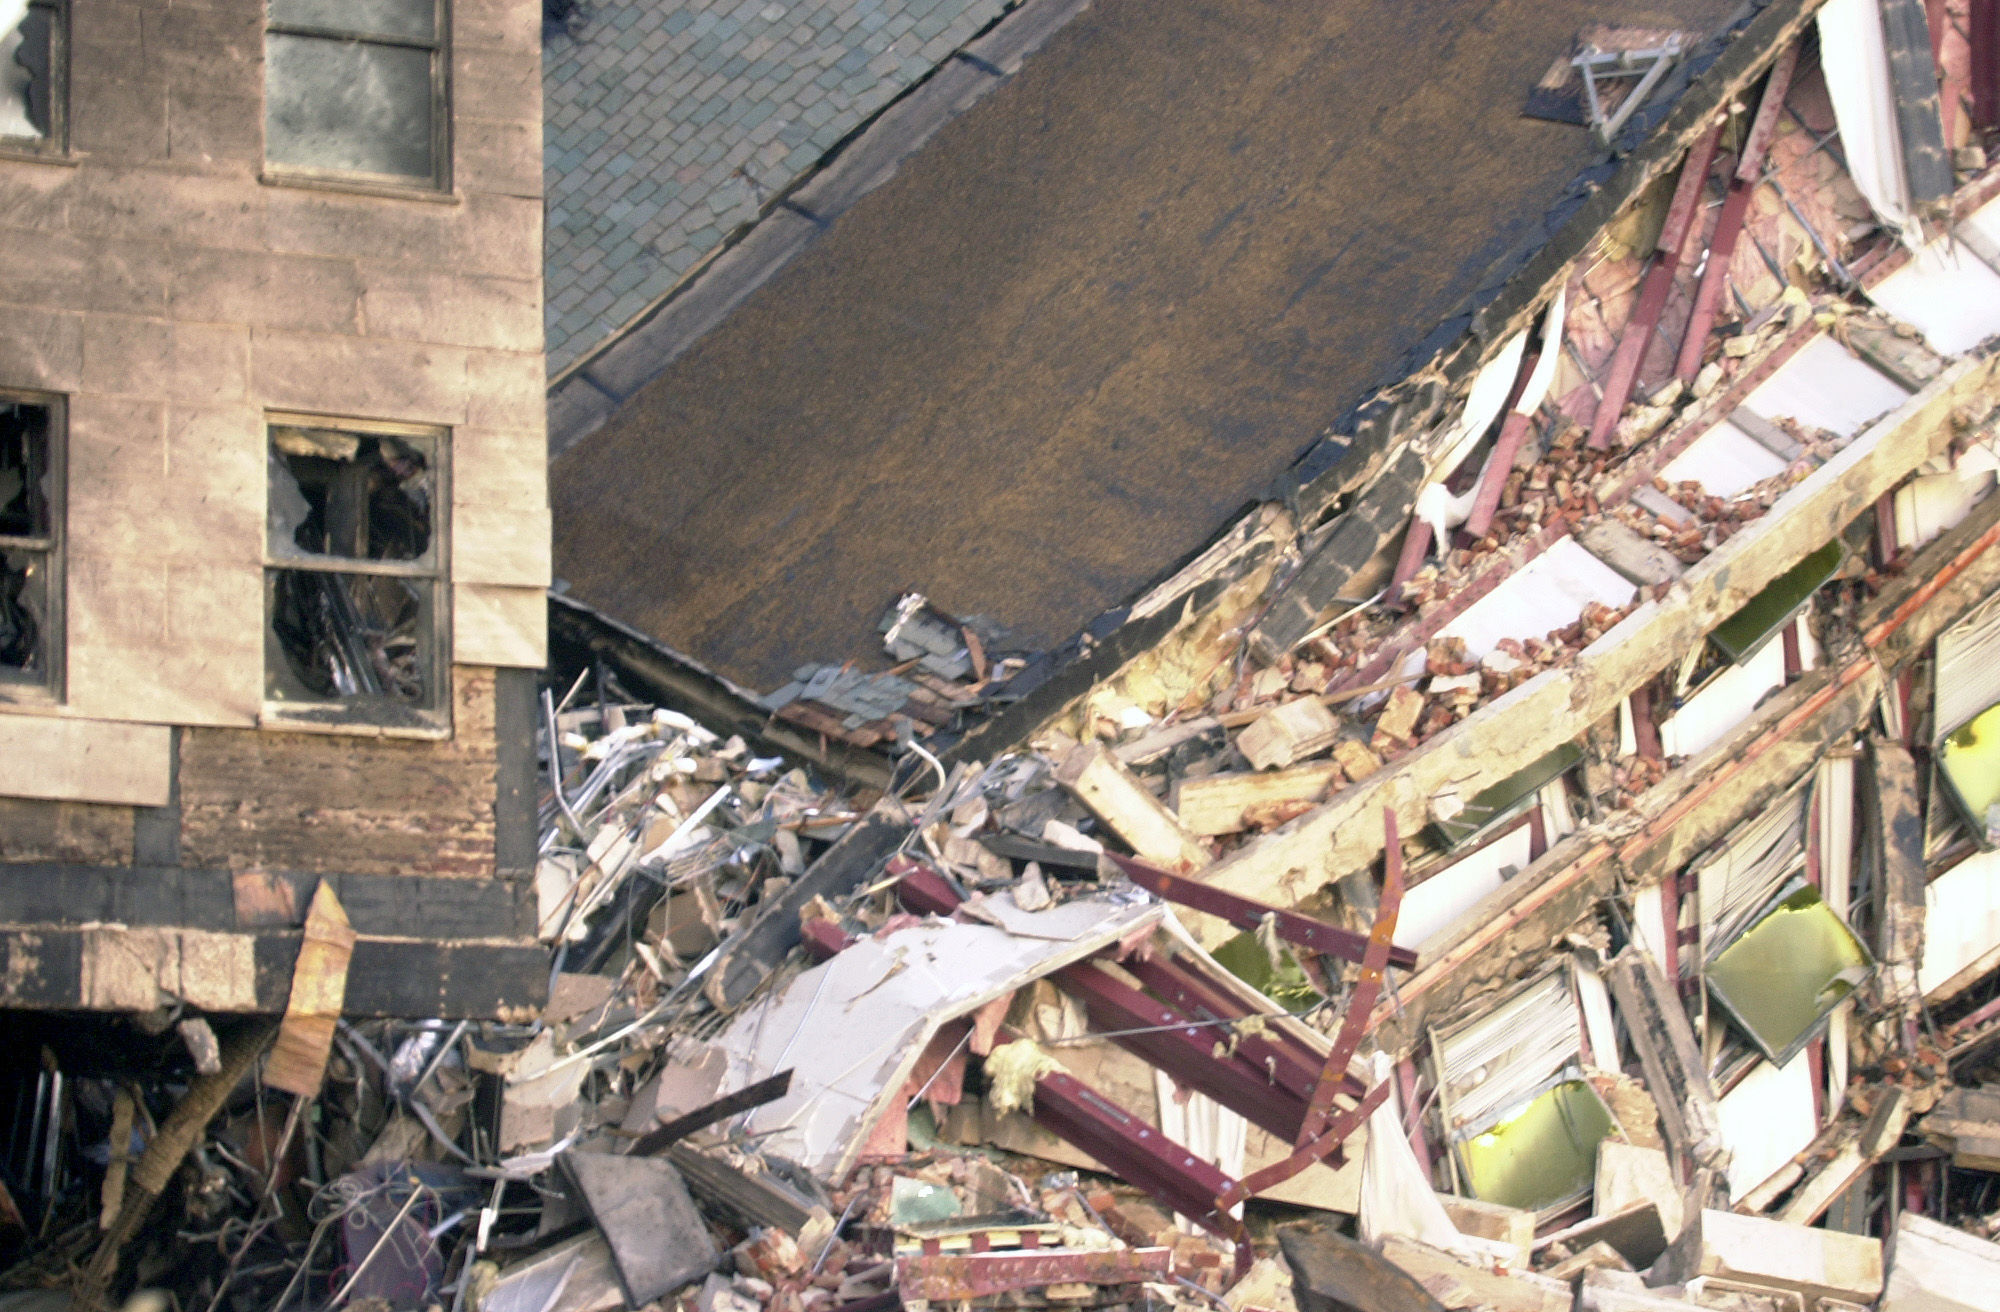

The entered image is a not a car. Please try again. Consider a different angle or lighting.


In [27]:
pathway('https://publicintelligence.net/wp-content/uploads/2011/09/DN-SD-03-114971.jpeg')

Ensuring entered picture is a car...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


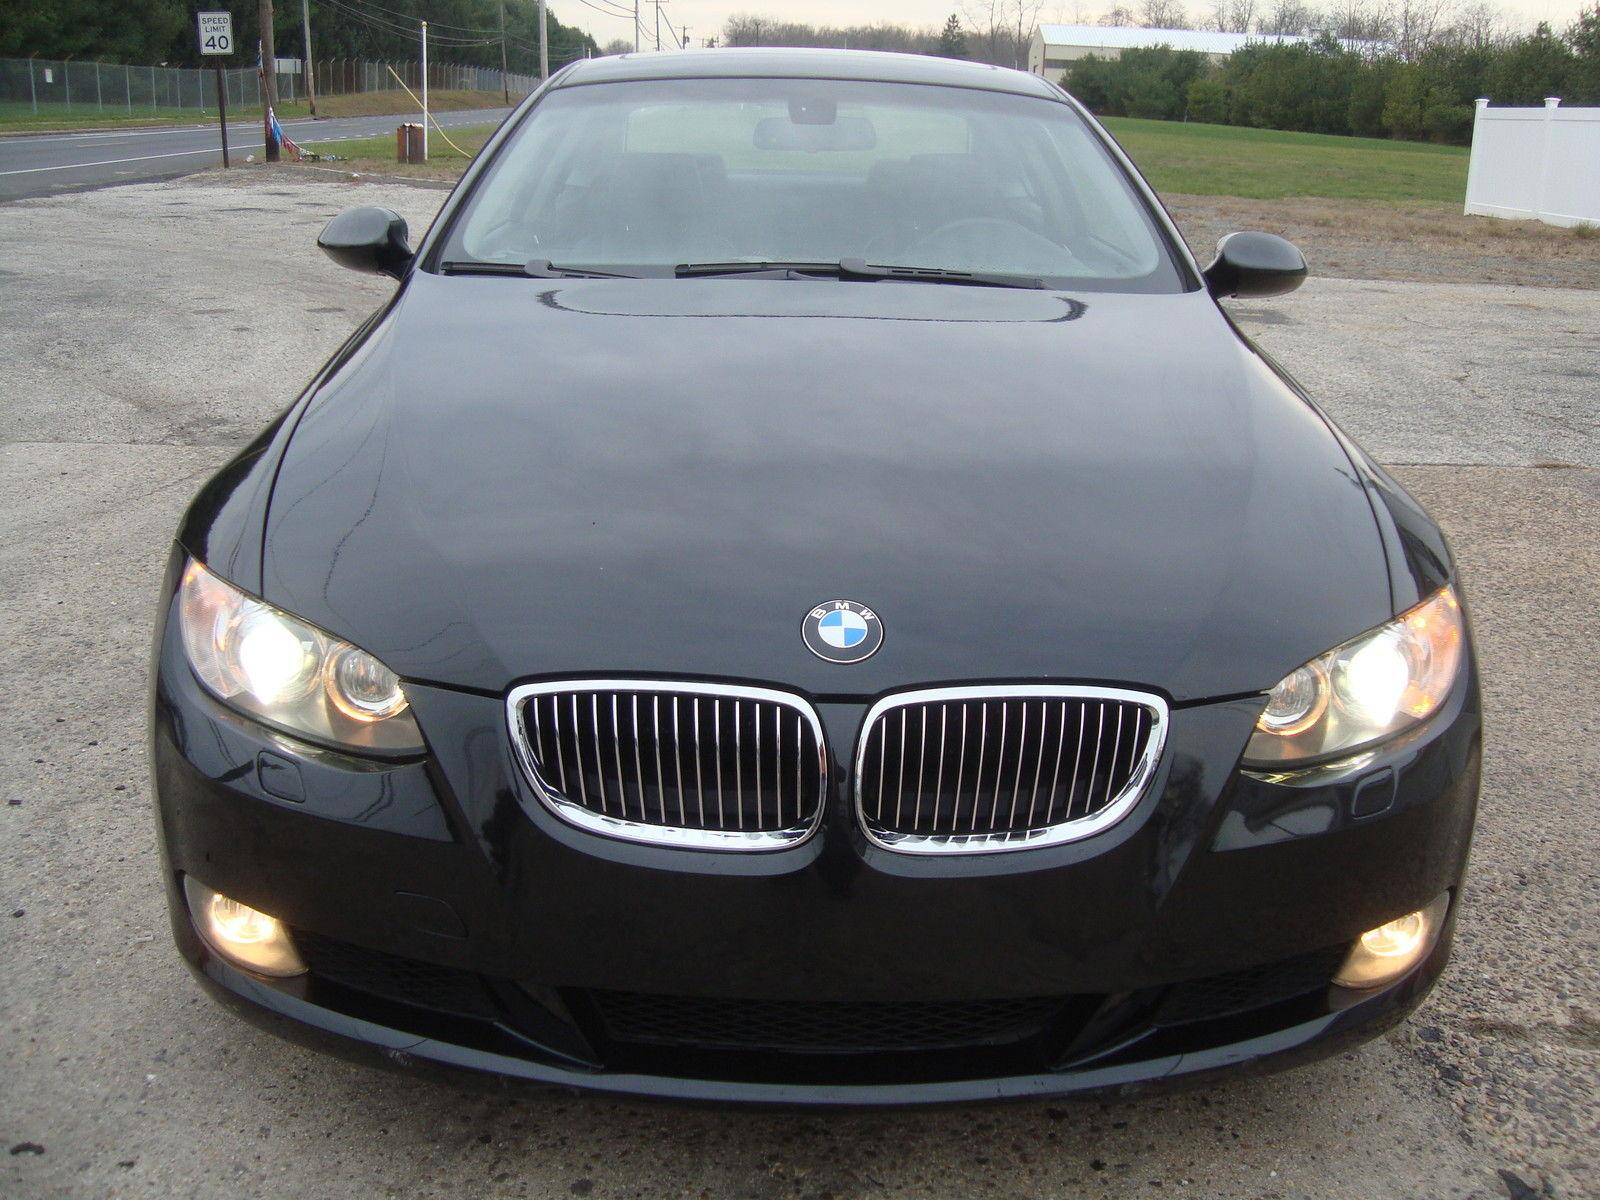

The entered image is a not a car. Please try again. Consider a different angle or lighting.


In [28]:
pathway('http://wrecked-sport-cars-for-sale.com/wp-content/wrecked-sport-cars-for-sale.com/2016/01/2009-bmw-328xi-coupe-salvage-rebuildable-wrecked-for-sale-2016-01-10-1.jpg')

In [31]:
import urllib.request

def prepare_image_224(img_path):
    # Add a User-Agent header to the request
    req = urllib.request.Request(img_path, headers={'User-Agent': 'Mozilla/5.0'})
    try:
        urllib.request.urlretrieve(req, 'save.jpg') # or other way to upload image
    except urllib.error.HTTPError as e:
        print(f"Error downloading image: {e}")
        # Handle the error, e.g., skip the image or use a default image
        return None  # Or raise the exception if necessary

    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [33]:
import urllib.request

def prepare_image_224(img_path):
    # Add a User-Agent header to the request
    req = urllib.request.Request(img_path, headers={'User-Agent': 'Mozilla/5.0'})
    try:
        # Use urlopen to open the request and then retrieve the content
        with urllib.request.urlopen(req) as response:
            with open('save.jpg', 'wb') as f:
                f.write(response.read())
    except urllib.error.HTTPError as e:
        print(f"Error downloading image: {e}")
        # Handle the error, e.g., skip the image or use a default image
        return None  # Or raise the exception if necessary

    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [36]:
def pathway(img_path):
    while True:
        #print("Submit image link (or type 'exit' to quit)")
        #img_path = input("Upload Image File Here:")
        #if img_path == 'exit':
        #    return None
        #clear_output()
        img_224 = prepare_image_224(img_path)
        # Check if image loading was successful
        if img_224 is None:
            print("Failed to load the image. Please check the URL or network connection.")
            break  # Exit the loop if image loading failed
        p1 = path1(img_224, model1)
        display(Image('save.jpg', width=300))
        if p1 is False:
            print("The entered image is a not a car. Please try again. Consider a different")

In [37]:
pathway('http://www.reshareable.tv/files/2014/06/6177_8_site_clear.jpeg')

Error downloading image: HTTP Error 404: Not Found
Failed to load the image. Please check the URL or network connection.


In [2]:
pathway('https://thumbs.dreamstime.com/z/damage-car-front-side-accident-43053232.jpg')

NameError: name 'pathway' is not defined

NameError: name 'pathway' is not defined